# <center> Previsão Vendas usando Regressão </center>

Para você que tem interesse em aprender fazer predição usando regressão no python, abaixo segue uma aplicação em dados de vendas de cosméticos que simula o que aparecerá na vida real.

In [1]:
!pip install pysal==1.14.4

In [2]:
!pip install feature-engine

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.regression.linear_model import OLS
from statsmodels.stats.stattools import durbin_watson

from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import linear_model
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from sklearn.preprocessing import scale


%matplotlib inline
import scipy as sp
import statsmodels.formula.api as sm
import statsmodels.api as sm

from scipy import stats

import statsmodels.api as sm



from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

pd.options.display.max_rows = 999
pd.set_option("display.float_format", lambda x: "%.2f" %x)

## <center> 1. Banco de Dados </center>

Abaixo têm-se a leitura do banco de dados

In [4]:
dados = pd.read_excel("Variaveis_ModeloPrediçao.xlsx")
dados = dados[(dados["Vendas"] != 0.01) & (dados["ano"] > 2018)] 
dados = dados.drop(['Unnamed: 0', 'Empresa', 'Departamento'], axis=1)


In [5]:
dados.columns

Index(['Data', 'Vendas', 'UnidadeNãoAbre', 'dia', 'mês', 'ano', 'Semana_Mês',
       'feriados', 'pagamento', 'Vale', 'domingo', 'segunda', 'terça',
       'quarta', 'quinta', 'sexta', 'sabado', 'Primeira_SemMes',
       'Segunda_SemMes', 'Terceira_SemMes', 'Quarta_SemMes', 'Quinta_SemMes',
       'PrimeiraSemMes', 'SegundaSemMes', 'TerceiraSemMes', 'QuartaSemMes',
       'QuintaSemMes'],
      dtype='object')

In [6]:
dados = dados.groupby(['Data', 'UnidadeNãoAbre', 'dia', 'mês', 'ano', 'Semana_Mês',
       'feriados', 'pagamento', 'Vale', 'domingo', 'segunda', 'terça',
       'quarta', 'quinta', 'sexta', 'sabado', 'Primeira_SemMes',
       'Segunda_SemMes', 'Terceira_SemMes', 'Quarta_SemMes', 'Quinta_SemMes',
       'PrimeiraSemMes', 'SegundaSemMes', 'TerceiraSemMes', 'QuartaSemMes',
       'QuintaSemMes'])['Vendas'].sum().reset_index()

### Objetivo

Fazer a predição das vendas de 2021-01-02 até 2021-02-28	

## <center> 2. Adição Variáveis </center>

### 2.1 Ponderação Mensal 

In [7]:
teste_SemIndice = dados

df = teste_SemIndice.copy()
df['Data'] = pd.to_datetime(df['Data'])
df['Data'] = df['Data'].dt.strftime('%Y-%m')

df_groupby = df.groupby("Data").agg( {"ano":["mean"],
                                      "mês":["mean"],
                                      "Vendas":["sum"] 
                                     } )
df_groupby = df_groupby.reset_index()
df_groupby.set_index('Data', inplace=True)

train_mensal = df_groupby[df_groupby.index < '2021-01'].copy()
test_mensal = df_groupby[df_groupby.index >= '2021-01'].copy()


#features = ["Data",'Feriado','Pagamento',"Vale",'outlier']
features = ["Data"]
target = "Vendas"

X_train_mensal, y_train_mensal = train_mensal[features], train_mensal[target]
X_test_mensal, y_test_mensal = test_mensal[features], test_mensal[target]



from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

df = y_train_mensal

result_mul = seasonal_decompose(df, 
                                period = 12,   
                                model='multiplicative', 
                                extrapolate_trend='freq')

### cria df coef ponderacao mes para cada mes de 1-12 

coef_mes = result_mul.seasonal[-12:].to_frame()
coef_mes['mês'] = pd.to_datetime(coef_mes.index).month


#merge das duas tabelas
dados = pd.merge(dados, coef_mes, how='left', on='mês')


dados = dados.rename(columns={'seasonal': 'pond_mensal'})

In [8]:
coef_mes

,seasonal,mês
Data,,
2020-01,0.99,1
2020-02,0.97,2
2020-03,1.16,3
2020-04,1.01,4
2020-05,1.00,5
2020-06,0.95,6
2020-07,0.95,7
2020-08,0.99,8
2020-09,0.93,9


### 2.2 Análise dos Outliers

In [9]:
outliers=[]


def find_outliers(data_set):
    
    corte_dp = 3
    media = np.mean(data_set)
    dp = np.std(data_set)
    
    for dado in data_set:
        
        z_score = (dado-media)/dp
        if np.abs(z_score) >= corte_dp:
            outliers.append(dado)
            
            
    return outliers
    

outliers = find_outliers(dados.Vendas)

outliers = pd.DataFrame(outliers)
outliers = outliers.rename(columns = {0:'Vendas'})

dados_outliers = pd.merge(dados, outliers, how = "inner", on= ["Vendas"])

Adição de Dummies dos Outliers 

### 2.3 Inserindo informações Públicas

In [10]:
def consulta_bc(codigo_bc):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bc)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst = True)
    df.set_index('data', inplace = True)
    return df.loc['2018-01-01' : '2021-03-31']

pib = consulta_bc(4380)
tx_selic = consulta_bc(4390)
desemprego = consulta_bc(24369) 
m1 = consulta_bc(27791)
igpm = consulta_bc(189)

data = [[pib, tx_selic, desemprego, igpm]]

index = pd.date_range(start = '2018-01-01', end = '2021-03-31', freq = "D")

df = pd.DataFrame(data, columns = [['Pib', 'Selic', 'Desemprego', 'IGP-M']], index = index)

data = [pib, tx_selic, desemprego, igpm]
df = pd.concat(data, axis=1)
df.columns = ['Pib', 'Selic', 'Desemprego', 'IGP-M']

df=df.reset_index()

In [11]:
df['mês_ano'] = df['data'].dt.strftime('%Y-%m')
df = df.drop(['data'], axis=1)


dados['mês_ano'] =dados['Data'].dt.strftime('%Y-%m')
dados = pd.merge(dados, df, how='left', on=['mês_ano'])

## <center> 3. Dados Prontos para serem usados </center>

In [12]:
## Colocando Data como índice
dados.set_index('Data', inplace = True)

#### Retirando dias faltantes da base que será checada previsão

## <center> 4. Modelagem </center>

### Correlação

Correlação das variáveis contínuas com as vendas

In [13]:
dados.columns

Index(['UnidadeNãoAbre', 'dia', 'mês', 'ano', 'Semana_Mês', 'feriados',
       'pagamento', 'Vale', 'domingo', 'segunda', 'terça', 'quarta', 'quinta',
       'sexta', 'sabado', 'Primeira_SemMes', 'Segunda_SemMes',
       'Terceira_SemMes', 'Quarta_SemMes', 'Quinta_SemMes', 'PrimeiraSemMes',
       'SegundaSemMes', 'TerceiraSemMes', 'QuartaSemMes', 'QuintaSemMes',
       'Vendas', 'pond_mensal', 'mês_ano', 'Pib', 'Selic', 'Desemprego',
       'IGP-M'],
      dtype='object')

In [14]:
## Retirando as variáveis categóricas 

dados_publicos = dados.drop(['UnidadeNãoAbre', 'dia', 'mês', 'ano', 'Semana_Mês', 'feriados',
       'pagamento', 'Vale', 'domingo', 'segunda', 'terça', 'quarta', 'quinta',
       'sexta', 'sabado', 'Primeira_SemMes', 'Segunda_SemMes',
       'Terceira_SemMes', 'Quarta_SemMes', 'Quinta_SemMes', 'PrimeiraSemMes',
       'SegundaSemMes', 'TerceiraSemMes', 'QuartaSemMes', 'QuintaSemMes',
       'mês_ano',  'pond_mensal'], axis=1)

In [15]:
corr =dados_publicos.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Vendas,Pib,Selic,Desemprego,IGP-M
Vendas,1.000000,0.052854,-0.077396,-0.013018,0.011913
Pib,0.052854,1.000000,-0.305968,0.290857,0.390271
Selic,-0.077396,-0.305968,1.000000,-0.757752,-0.685485
Desemprego,-0.013018,0.290857,-0.757752,1.000000,0.764377
IGP-M,0.011913,0.390271,-0.685485,0.764377,1.000000


### 4.1 3. Separando em treino e teste

### Antes de rodar o código abaixo é necessário:

* Em exogenas - Retirar todas as variáveis que não vão entrar no modelo na parte de variáveis externas.

###### OBS: Não esquecer de retirar o dia da semana e a semana do mês que será referência

* A semana do mês de referência será a quinta semana.
* Dia da semana de referência: Segunda-feira

In [27]:
dados.columns

Index(['UnidadeNãoAbre', 'dia', 'mês', 'ano', 'Semana_Mês', 'feriados',
       'pagamento', 'Vale', 'domingo', 'segunda', 'terça', 'quarta', 'quinta',
       'sexta', 'sabado', 'Primeira_SemMes', 'Segunda_SemMes',
       'Terceira_SemMes', 'Quarta_SemMes', 'Quinta_SemMes', 'PrimeiraSemMes',
       'SegundaSemMes', 'TerceiraSemMes', 'QuartaSemMes', 'QuintaSemMes',
       'Vendas', 'pond_mensal', 'mês_ano', 'Pib', 'Selic', 'Desemprego',
       'IGP-M'],
      dtype='object')

In [41]:
t_treino = dados.Vendas[dados.Vendas.index <'2020-10-01'].index.values
t_teste = dados.Vendas[(dados.Vendas.index >= '2020-10-01') & (dados.Vendas.index < '2021-01-01')].index.values
Y_treino  = dados.Vendas[dados.Vendas.index < '2020-10-01'].values
Y_teste  = dados.Vendas[(dados.Vendas.index >= '2020-10-01') & (dados.Vendas.index < '2021-01-01')].values

exogenas = dados.drop(['UnidadeNãoAbre', 'dia', 'mês', 'ano', 'Semana_Mês', 'feriados', 'pagamento', 'Vale', 
                       'segunda', 'Quinta_SemMes', 'PrimeiraSemMes','SegundaSemMes', 'TerceiraSemMes', 
                       'QuartaSemMes', 'QuintaSemMes','pond_mensal', 'Vendas', 'mês_ano', 'Pib',
                       'Selic','Desemprego', 'IGP-M'], axis =1)

t_treino_exog = exogenas[exogenas.index < '2020-10-01'].index.values
t_teste_exog = exogenas[(exogenas.index >= '2020-10-01') & (exogenas.index < '2021-01-01')].index.values
X_treino_exog = exogenas[exogenas.index <'2020-10-01'].values
X_teste_exog = exogenas[(exogenas.index >= '2020-10-01') & (exogenas.index < '2021-01-01')].values

In [53]:
exogenas

,domingo,terça,quarta,quinta,sexta,sabado,Primeira_SemMes,Segunda_SemMes,Terceira_SemMes,Quarta_SemMes
Data,,,,,,,,,,
2019-01-02,0,0,1,0,0,0,0,0,0,1
2019-01-03,0,0,0,1,0,0,0,0,0,0
2019-01-04,0,0,0,0,1,0,0,0,0,0
2019-01-05,0,0,0,0,0,1,0,0,0,0
2019-01-06,1,0,0,0,0,0,1,0,0,0
2019-01-07,0,0,0,0,0,0,0,1,0,0
2019-01-08,0,1,0,0,0,0,0,0,1,0
2019-01-09,0,0,1,0,0,0,0,0,0,1
2019-01-10,0,0,0,1,0,0,0,0,0,0


#### 4.1 4. Modelagem 

In [43]:
modelPond = LinearRegression().fit(X_treino_exog, Y_treino)

In [52]:
## Acurácia modelo base treino
print("Acurácia modelo base treino")
print('R2 =', modelPond.score(X_treino_exog, Y_treino)) 

previsao = modelPond.predict(X_teste_exog)    ## Previsão da base de teste
residuo = Y_teste - previsao                   ## Resíduo da base de teste com o predito

#### Acurácia do modelo Base teste
from sklearn.metrics import mean_absolute_error, mean_squared_error

R2 = r2_score(Y_teste, previsao)
MAE = mean_absolute_error(Y_teste, previsao)
RMSE = np.sqrt(mean_squared_error(Y_teste, previsao))

print("\nAcurácia modelo da base teste")
print("MAE = {:0.2f}".format(MAE))
print("RMSE = {:0.2f}".format(RMSE))
print("R2 = {:0.2f}".format(R2))

Acurácia modelo base treino
R2 = 0.5218266066755473

Acurácia modelo da base teste
MAE = 35093.78
RMSE = 68475.95
R2 = 0.21


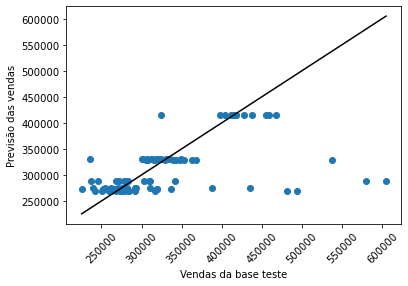

In [57]:
## Reta de regressão dados de teste X predito

import matplotlib.pyplot as plt
%matplotlib inline

def scatterPlot(actual, predicted):
    plt.scatter(actual, predicted)
    range = [actual.min(), actual.max()]
    plt.plot(range, range, 'black')
    plt.xlabel("Vendas da base teste")
    plt.ylabel("Previsão das vendas")
    plt.xticks(rotation=45)
    plt.show()
    
scatterPlot(Y_teste, previsao)

(array([18536., 18550., 18567., 18581., 18597., 18611., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

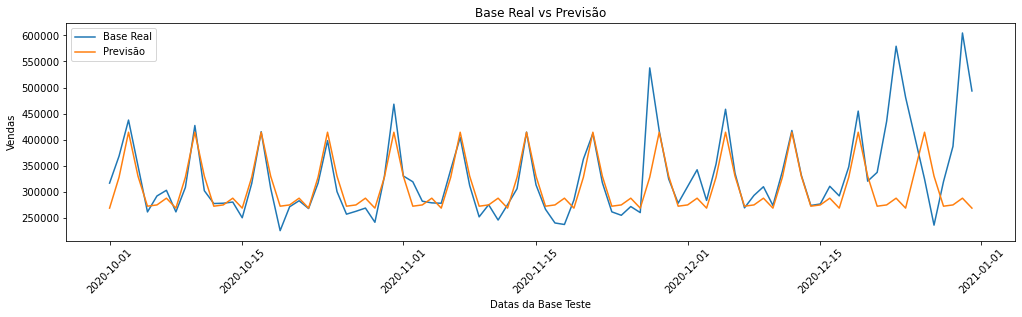

In [66]:
plt.subplots(figsize=(17,4), sharex=True)

plt.plot(t_teste,Y_teste,label='Base Real')
plt.plot(t_teste,previsao,label='Previsão')
plt.legend()
plt.title('Base Real vs Previsão')
plt.xlabel('Datas da Base Teste')
plt.ylabel('Vendas')
plt.xticks(rotation=45)
## Alterar espaçamento eixo x
#plt.xticks(t_teste[::2])


### Regressão

In [68]:
x_real3 = exogenas[exogenas.index <'2020-10-01']

In [69]:
X = x_real3[x_real3.index <'2020-10-01']
y = Y_treino
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est_pond_sig = est.fit()
print(est_pond_sig.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     114.1
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           4.43e-97
Time:                        23:09:21   Log-Likelihood:                -7709.0
No. Observations:                 634   AIC:                         1.543e+04
Df Residuals:                     627   BIC:                         1.546e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             2.66e+05   1636.514    1

## <center> Validação Cruzada - K-folds </center>

Uma das melhores técnicas para saber se o seu modelo generaliza bem, ou seja, como o modelo se comporta quando vai prever um dado que nunca viu.

In [71]:
Validação  = exogenas[exogenas.index < "2021-01-01"]

validação_Y = dados[dados.index < "2021-01-01"]

In [72]:
## Fazer Validação cruzada, é utilizada a base de dados inteira.
y = validação_Y.Vendas
lm = linear_model.LinearRegression()
model = lm.fit(Validação, y)
predictions = lm.predict(Validação)

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import cross_val_score # Cross Validation Function.
from sklearn.model_selection import KFold # KFold Class.
from sklearn.linear_model import LinearRegression # Linear Regression class.
from sklearn.metrics import mean_squared_error

model  = LinearRegression()
kfold  = KFold(n_splits=10, shuffle=True) ## n_splits=10 quantidade de interações, valor de k
result = cross_val_score(model,Validação, y, cv = kfold)

predictions = cross_val_predict(model,Validação,y,cv=kfold)


print("K-Fold (R^2) Scores: {0}".format(result))
print("Mean R^2 for Cross-Validation K-Fold: {0}".format(result.mean()))
print("Verdadeiro Score que o modelo está generalizando  K-Fold: {0}".format(result.mean()))

print('Média: {:.2} | Desvio: {:.2}'.format(np.mean(result), np.std(result)))

K-Fold (R^2) Scores: [0.6213904  0.7062285  0.29762849 0.37791313 0.58190879 0.39976819
 0.18950729 0.39445748 0.68348152 0.57881633]
Mean R^2 for Cross-Validation K-Fold: 0.4831100127295708
Verdadeiro Score que o modelo está generalizando  K-Fold: 0.4831100127295708
Média: 0.48 | Desvio: 0.17


Agora temos o nosso R² para K iterações com dados de treinos e teste aleatórios. 

### <center> Verificando a peformance de varios modelos </center>

Criar uma função que veja a performance (R²) de vários modelos (Ex: Regressão) e escolha o melhor

In [78]:
def ApplyesKFold(x_axis, y_axis):
  # Linear Models.
  from sklearn.linear_model import LinearRegression
  from sklearn.linear_model import ElasticNet
  from sklearn.linear_model import Ridge
  from sklearn.linear_model import Lasso

  # Cross-Validation models.
  from sklearn.model_selection import cross_val_score
  from sklearn.model_selection import KFold

  # KFold settings.
  kfold  = KFold(n_splits=10, shuffle=True) # shuffle=True, Shuffle (embaralhar) the data.

  # Axis
  x = x_axis
  y = y_axis

  # Models instances.
  linearRegression = LinearRegression()
  elasticNet       = ElasticNet()
  ridge            = Ridge()
  lasso            = Lasso()

  # Applyes KFold to models.
  linearRegression_result = cross_val_score(linearRegression, x, y, cv = kfold)
  elasticNet_result       = cross_val_score(elasticNet, x, y, cv = kfold)
  ridge_result            = cross_val_score(ridge, x, y, cv = kfold)
  lasso_result            = cross_val_score(lasso, x, y, cv = kfold)

  # Creates a dictionary to store Linear Models.
  dic_models = {
    "LinearRegression": linearRegression_result.mean(),
    "ElasticNet": elasticNet_result.mean(),
    "Ridge": ridge_result.mean(),
    "Lasso": lasso_result.mean()
  }
  # Select the best model.
  bestModel = max(dic_models, key=dic_models.get)

  print("Linear Regression Mean (R^2): {0}\nElastic Net Mean (R^2): {1}\nRidge Mean (R^2): {2}\nLasso Mean (R^2): {3}".format(linearRegression_result.mean(), elasticNet_result.mean(), ridge_result.mean(), lasso_result.mean()))
  print("The best model is: {0} with value: {1}".format(bestModel, dic_models[bestModel]))


if __name__ =='__main__':
  import pandas as pd

  dados
        
  x = Validação
 
  y = y

  ApplyesKFold(x, y)

Linear Regression Mean (R^2): 0.487341074727083
Elastic Net Mean (R^2): 0.19769387165665026
Ridge Mean (R^2): 0.4741967580891274
Lasso Mean (R^2): 0.4818554946066314
The best model is: LinearRegression with value: 0.487341074727083


C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19092384442.507324, tolerance: 297345618.6577705
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18802913762.336426, tolerance: 310969388.96617454
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11788458684.332031, tolerance: 297988561.4644764
  model = cd_fast.enet_coordinate_descent(
C:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increas